In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
#code.global_options()

In [3]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00', #memory='120GB',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# Optical absorption of the AGSLn with n=6

We study the optical absorption spectrum of the AGSL6.

## IP absorption on top of the DFT analysis

We study the absorption spectrum on top of the DFT analysis in function of the k-points sampling.

We can compute the polarizability due to a field polarized along the y direction

In [4]:
ksamplings = {'5x15': {'folder':'kpoints_5x15-nbnds_600','npoints':24},
             '8x24': {'folder':'kpoints_8x24-nbnds_800','npoints':65},
             '12x36': {'folder':'kpoints_12x36-nbnds_600','npoints':133},
            }

In [5]:
RandGvec = 100
RandQpts = 5e6

dft_gap = 0.0779
gw_gap = 0.321
scissor = gw_gap-dft_gap

energy_range = [0,6] # eV
damping = [0.07,0.07] # eV
BLongDir = [0.0,1.0,0.0]
BSEBands = [1,100]

study = D.Dataset(num_tasks=3,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    inp = I.YamboInput('yambo -r -o b -k IP',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BLongDir=BLongDir,KfnQP_E=[scissor,1.,1.],BSEBands=BSEBands)
    idd = 'abs-ip-yPol-kpoints_%s'%k
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'pp-G-kpoints_%s'%k,'ndbs-ngsblkxp_6.0-bndsrnxp_500','ndbs'])

Initialize a Dataset with 3 parallel tasks


In [6]:
study.ids

['abs-ip-yPol-kpoints_5x15',
 'abs-ip-yPol-kpoints_8x24',
 'abs-ip-yPol-kpoints_12x36']

In [7]:
#study.runs[2]

In [8]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of abs-ip-yPol-kpoints_8x24
Skip the run of abs-ip-yPol-kpoints_5x15
Skip the run of abs-ip-yPol-kpoints_12x36
Task [0, 1, 2] ended 
 


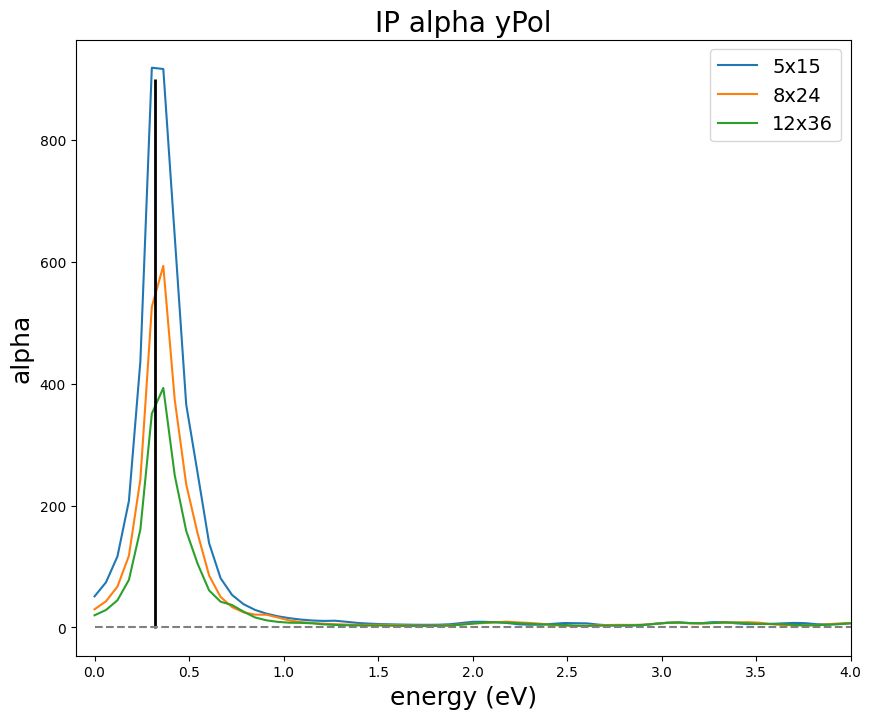

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(ksamplings):
    data = results[ind].data['alpha_q1_IP']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label=k) 
ax.vlines(gw_gap,-0.5,900,linestyles='-',color='black',linewidth=2)
ax.hlines(0,xmin=0,xmax=energy[-1],linestyles='--',color='gray')
ax.set_xlim(-0.1,4)
#ax.set_ylim(-5,100)
ax.set_ylabel('alpha',size=18)
ax.set_xlabel('energy (eV)',size=18)
ax.set_title('IP alpha yPol',size=20)
ax.legend(fontsize=14)

## BSE Analysis

We perform this analysis using a previous release of Yambo because the 5.2.3 seems to have a problem when
running the slepc with the actual Leonardo implementation.

In [14]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.0_gpu'
#module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.3_gpu'


ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.2.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We perform the BSE analysis to compute the absorption spectrum and the excitonic energies.

We perform this analysis for various values of the relevant paramters and k-samplings to check the convergence 
of the BSE results. Computations are performed by including a scissor provided by the GW correction at the $\Gamma$ point to the DFT KS energies

In [15]:
ksamplings = {'5x15': {'folder':'kpoints_5x15-nbnds_600','npoints':24},
             '8x24': {'folder':'kpoints_8x24-nbnds_800','npoints':65},
             '12x36': {'folder':'kpoints_12x36-nbnds_600','npoints':133},
            }

In [16]:
start_band,stop_band = 49,50
Gamma_index = 1

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False)
ksamplings

Parse file MB_analysis/kpoints_5x15-nbnds_600/pp-G-kpoints_5x15/o-pp-G-kpoints_5x15.qp
Parse file MB_analysis/kpoints_8x24-nbnds_800/pp-G-kpoints_8x24/o-pp-G-kpoints_8x24.qp
Parse file MB_analysis/kpoints_12x36-nbnds_600/pp-G-kpoints_12x36/o-pp-G-kpoints_12x36.qp


{'5x15': {'folder': 'kpoints_5x15-nbnds_600',
  'npoints': 24,
  'gw_gap': 0.253946},
 '8x24': {'folder': 'kpoints_8x24-nbnds_800',
  'npoints': 65,
  'gw_gap': 0.302679},
 '12x36': {'folder': 'kpoints_12x36-nbnds_600',
  'npoints': 133,
  'gw_gap': 0.321425}}

### Convergence of the BSEBands and of the BSENGBlk parameter

First we test the effects of the number of BSE bands and of the cutoff in the BSE matrix in the smaller k-sampling.

On the basis of the analysis performed for the AGSL5 we assume that the value BSENGBlk = 3 Ha is reasonably converged. 

Then we explore the converge on the bands parameter.

In [21]:
kpoints = '8x24'
run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [0.,1.,0.]
BSEBands = [[46,53],[42,57],[40,60]]
BEnRange = [-0.5,4] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.1,0.1] # eV

dft_gap = 0.0779
scissor = ksamplings[kpoints]['gw_gap'] - dft_gap

study = D.Dataset(num_tasks=3,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping) #,BSSEnTarget=BSSEnTarget
inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
#inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
#inp.set_scalar_variables(BS_CPU='16.1.1',BS_ROLEs= 'k.eh.t') # 4 nodes on leonardo  

for bands in BSEBands:
    inp.set_array_variables(BSEBands=bands,BEnSteps=BEnSteps,BSSNEig=BSSNEig) #,BSSSlepcMaxIt=BSSSlepcMaxIt
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    idd = 'bse-bsengblk_%s-bands_%s-%s'%(BSENGBlk,bands[0],bands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndbs','ndbs-ngsblkxp_6.0-bndsrnxp_500'],reformat=False) #,'ndbs_bse'

Initialize a Dataset with 3 parallel tasks


In [26]:
study.ids

['bse-bsengblk_3.0-bands_46-53',
 'bse-bsengblk_3.0-bands_42-57',
 'bse-bsengblk_3.0-bands_40-60']

In [24]:
#study.runs[0]

In [27]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of bse-bsengblk_3.0-bands_46-53
Skip the run of Skip the run ofbse-bsengblk_3.0-bands_42-57 
bse-bsengblk_3.0-bands_40-60
Task [0, 1, 2] ended 
 


In [28]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.120547, 0.249467, 0.28192 , 0.340222, 0.363897, 0.418464,
       0.469595, 0.526143, 0.626104, 0.671879, 0.75734 , 0.7663  ,
       0.82342 , 0.859887, 0.905584])

In [29]:
exc_eng = results[1].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.119324, 0.249437, 0.281595, 0.340115, 0.363887, 0.418427,
       0.469591, 0.526141, 0.625736, 0.669542, 0.756776, 0.757778,
       0.766253, 0.822459, 0.859882, 0.905582])

In [30]:
exc_eng = results[2].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.118999, 0.249428, 0.281511, 0.340088, 0.363884, 0.418419,
       0.469591, 0.526139, 0.625686, 0.668842, 0.756754, 0.757763,
       0.766243, 0.822045, 0.859881, 0.905581])

In [31]:
bind_eng = ksamplings[kpoints]['gw_gap']-exc_eng[0]
bind_eng

0.18367999999999998

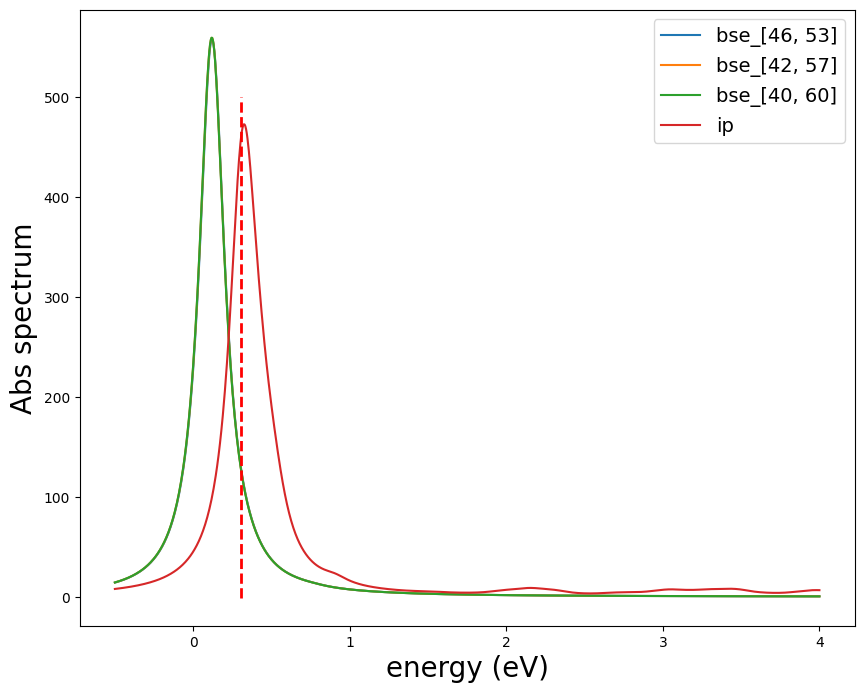

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(BSEBands)):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,eps_im,label='bse_%s'%BSEBands[ind])
eps_o_im = data['alpha_o_imag']
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(ksamplings[kpoints]['gw_gap'],-1,500,linestyles='--',color='red',linewidth=2)
#ax.set_xlim(1.5,4)
#ax.set_ylim(-1e-4,5e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

### Convergence in terms of the k-sampling

We investigate the convergence of the BSE spectrum and excitonic energies in function of the k-points samplings.

For this analysis we use the converged values

BSENGBlk = 3.0 # Ha  
BSEBands = [46,53]

In [41]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [0.,1.,0.]
BSEBands = [46,53]
BEnRange = [-0.5,4] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.1,0.1] # eV

dft_gap = 0.0779
scissor = ksamplings[kpoints]['gw_gap'] - dft_gap

study = D.Dataset(num_tasks=4,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    scissor = ksamplings[kpoints]['gw_gap'] - dft_gap
    inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
    inp.set_scalar_variables(BSEprop= 'abs esrt') # esrt
    inp.set_scalar_variables(BS_CPU='4.1.1',BS_ROLEs= 'k.eh.t') # 1 nodes on leonardo  
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    idd = 'bse-bsengblk_%s-bands_%s-%s-kpoints_%s'%(BSENGBlk,BSEBands[0],BSEBands[1],kpoints)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndbs','ndbs-ngsblkxp_6.0-bndsrnxp_500','bse-bsengblk_3.0-bands_46-53'],reformat=False)

Initialize a Dataset with 4 parallel tasks


In [42]:
study.ids

['bse-bsengblk_3.0-bands_46-53-kpoints_5x15',
 'bse-bsengblk_3.0-bands_46-53-kpoints_8x24',
 'bse-bsengblk_3.0-bands_46-53-kpoints_12x36']

In [44]:
#study.runs[2]

In [45]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F bse-bsengblk_3.0-bands_46-53-kpoints_5x15.in -J "bse-bsengblk_3.0-bands_46-53-kpoints_5x15,ndbs,ndbs-ngsblkxp_6.0-bndsrnxp_500,bse-bsengblk_3.0-bands_46-53" -C bse-bsengblk_3.0-bands_46-53-kpoints_5x15run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F bse-bsengblk_3.0-bands_46-53-kpoints_12x36.in -J "bse-bsengblk_3.0-bands_46-53-kpoints_12x36,ndbs,ndbs-ngsblkxp_6.0-bndsrnxp_500,bse-bsengblk_3.0-bands_46-53" -C bse-bsengblk_3.0-bands_46-53-kpoints_12x36run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F bse-bsengblk_3.0-bands_46-53-kpoints_8x24.in -J "bse-bsengblk_3.0-bands_46-53-kpoints_8x24,ndbs,ndbs-ngsblkxp_6.0-bndsrnxp_500,bse-bsengblk_3.0-bands_46-53" -C bse-bsengblk_3.0-bands_46-53-kpoints_8x24


slurm submit: slurm submit: slurm submit:    cd MB_analysis/kpoints_12x36-nbnds

In [46]:
exc_ind = 0 # index of the excitation. 0 = first excitation energy
excitations = []
kpoints = np.arange(1,len(ksamplings.keys())+1)
for ind in range(len(ksamplings.keys())):
    excitations.append(results[ind].data['Esort_q1_slepc_bse']['energy'][exc_ind])
excitations,kpoints

([0.086916, 0.120547, 0.142797], array([1, 2, 3]))

In [47]:
ksamplings

{'5x15': {'folder': 'kpoints_5x15-nbnds_600',
  'npoints': 24,
  'gw_gap': 0.253946},
 '8x24': {'folder': 'kpoints_8x24-nbnds_800',
  'npoints': 65,
  'gw_gap': 0.302679},
 '12x36': {'folder': 'kpoints_12x36-nbnds_600',
  'npoints': 133,
  'gw_gap': 0.321425}}

Text(0.5, 1.0, 'First excitation and GW gap')

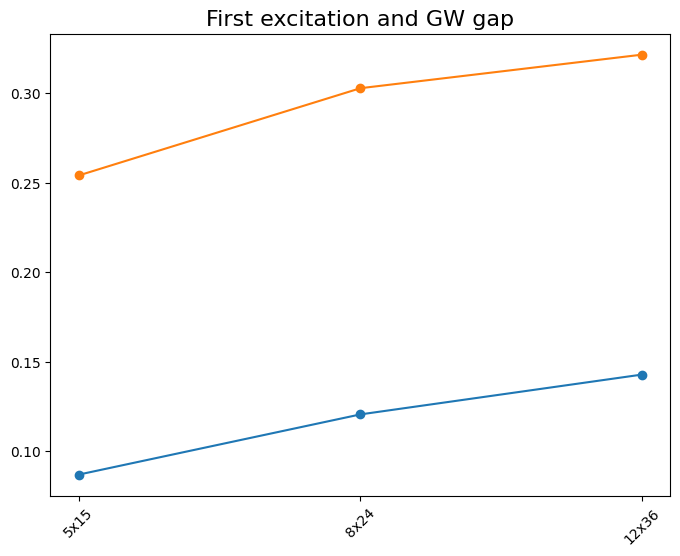

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(kpoints,excitations)
ax.plot(kpoints,excitations)
gw_gaps = [ksamplings[k]['gw_gap'] for k in ksamplings]
ax.scatter(kpoints,gw_gaps)
ax.plot(kpoints,gw_gaps)
labels = list(ksamplings.keys())
plt.xticks(kpoints, labels, rotation=45,size=10)
ax.set_title('First excitation and GW gap',size=16)
#ax.set_ylim(0.42,0.55)

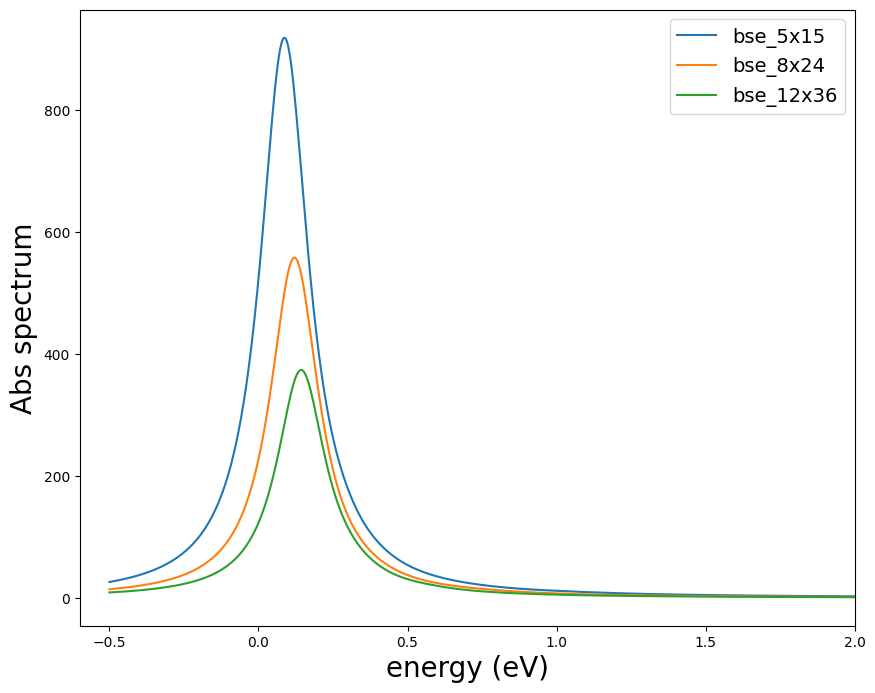

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(3):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    eps_im = data['alpha_imag']
    ax.plot(energy,eps_im,label='bse_%s'%list(ksamplings.keys())[ind])
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(-0.6,2)
ax.legend(fontsize=14)